In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tr

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

from typing import Optional, Union

from torch import Tensor
from torch.nn import Linear
from torch_geometric.nn.conv import MessagePassing, GravNetConv
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_scatter import scatter

from tqdm.notebook import tqdm

import numpy as np

import json
import math
import os
import time
import pickle as pkl

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [2]:
# VICReg loss function
def criterion(x, y, device="cuda", lmbd=25, u=25, v=1, epsilon=1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T @ yNorm) / bs
    cross_loss = (
        (
            crossCorMat * lmbd
            - torch.eye(emb, device=torch.device(device)) * lmbd
        )
        .pow(2)
        .sum()
    )

    loss = u * var_loss + v * invar_loss + cross_loss

    return loss

# CLIC

In [5]:
! ls ../data/clic/gev380ee_pythia6_higgs_bbar_full201/processed/data_0.pt

data_0.pt


In [6]:
import glob

all_files = glob.glob(
    f"../data/clic/gev380ee_pythia6_higgs_bbar_full201/processed/data_0.pt"
)

In [7]:
# load the clic dataset
data = []
for f in all_files:
    data += torch.load(f"{f}")

In [8]:
loader = torch_geometric.loader.DataLoader(data, batch_size=1, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

A single event: 
 Batch(x=[103, 12], ygen=[103, 5], ygen_id=[103], ycand=[103, 5], ycand_id=[103], batch=[103], ptr=[2])


In [9]:
print(f"num of clic events {len(loader)}")

num of clic events 9233


## From event to tracks/clusters

In [10]:
CLUSTERS_X = 6
TRACKS_X = 11
COMMON_X = 11

In [11]:
# function that takes an event~Batch() and splits it into two Batch() objects representing the tracks/clusters
def distinguish_PFelements(batch):

    track_id = 1
    cluster_id = 2

    tracks = Batch(
        x=batch.x[batch.x[:, 0] == track_id][
            :, 1:
        ].float(),  # remove the first input feature which is not needed anymore
        ygen=batch.ygen[batch.x[:, 0] == track_id],
        ygen_id=batch.ygen_id[batch.x[:, 0] == track_id],
        ycand=batch.ycand[batch.x[:, 0] == track_id],
        ycand_id=batch.ycand_id[batch.x[:, 0] == track_id],
        batch=batch.batch[batch.x[:, 0] == track_id],
    )
    clusters = Batch(
        x=batch.x[batch.x[:, 0] == cluster_id][:, 1:].float()[
            :, :CLUSTERS_X
        ],  # remove the first input feature which is not needed anymore
        ygen=batch.ygen[batch.x[:, 0] == cluster_id],
        ygen_id=batch.ygen_id[batch.x[:, 0] == cluster_id],
        ycand=batch.ycand[batch.x[:, 0] == cluster_id],
        ycand_id=batch.ycand_id[batch.x[:, 0] == cluster_id],
        batch=batch.batch[batch.x[:, 0] == cluster_id],
    )

    return tracks, clusters


# conversly, function that combines the learned latent representations back into one Batch() object
def combine_PFelements(tracks, clusters):

    #     zero padding
    #     clusters.x = torch.cat([clusters.x, torch.from_numpy(np.zeros([clusters.x.shape[0],TRACKS_X-CLUSTERS_X]))], axis=1)

    event = Batch(
        x=torch.cat([tracks.x, clusters.x]),
        ygen=torch.cat([tracks.ygen, clusters.ygen]),
        ygen_id=torch.cat([tracks.ygen_id, clusters.ygen_id]),
        ycand=torch.cat([tracks.ycand, clusters.ycand]),
        ycand_id=torch.cat([tracks.ycand_id, clusters.ycand_id]),
        batch=torch.cat([tracks.batch, clusters.batch]),
    )

    return event

In [12]:
tracks, clusters = distinguish_PFelements(batch)

print(f"event:    {batch}")
print(f"tracks:   {tracks}")
print(f"clusters: {clusters}")

event:    Batch(x=[103, 12], ygen=[103, 5], ygen_id=[103], ycand=[103, 5], ycand_id=[103], batch=[103], ptr=[2])
tracks:   Batch(x=[34, 11], ygen=[34, 5], ygen_id=[34], ycand=[34, 5], ycand_id=[34], batch=[34])
clusters: Batch(x=[69, 6], ygen=[69, 5], ygen_id=[69], ycand=[69, 5], ycand_id=[69], batch=[69])


# VICreg

In [13]:
# define the Encoder that learns latent representations of tracks and clusters
# these representations will be used by MLPF which is the downstream task
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim=11,
        embedding_dim=34,
        num_convs=2,
    ):
        super(Encoder, self).__init__()

        self.act = nn.ELU

        ### 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(TRACKS_X, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(CLUSTERS_X, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )

        ### 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=16,
                )
            )

    def forward(self, tracks, clusters):

        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)

        return embedding_tracks, embedding_clusters

In [14]:
# define the decoder that expands the latent representations of tracks and clusters
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim=34,
        output_dim=200,
    ):
        super(Decoder, self).__init__()

        self.act = nn.ELU

        ############################ DECODER
        self.expander = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, output_dim),
        )

    def forward(self, out_tracks, out_clusters):

        return self.expander(out_tracks), self.expander(out_clusters)

In [15]:
# retrieve a batch with batch_size>1
loader = torch_geometric.loader.DataLoader(data, batch_size=2)
for batch in loader:
    break

# retrieve the tracks and clusters
tracks, clusters = distinguish_PFelements(batch)

# setup VICReg
encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)

# make encoder forward pass
embedding_tracks, embedding_clusters = encoder(tracks, clusters)

# pooling
pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)

# make decoder forward pass
out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

# compute the loss between the two latent representations
loss = criterion(out_tracks, out_clusters, device="cpu")
print("loss is: ", loss.item())

loss is:  6351292.0


In [21]:
# train the encoder
def train_VICReg(encoder, decoder, data, batch_size, lr, epochs, lmbd, u, v):

    data_train = data[: int(0.8 * len(data))]
    data_valid = data[int(0.8 * len(data)) :]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    valid_loader = torch_geometric.loader.DataLoader(data_valid, batch_size)

    optimizer = torch.optim.SGD(
        list(encoder.parameters()) + list(decoder.parameters()),
        lr=lr,
        momentum=0.9,
        weight_decay=1.5e-4,
    )

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    for epoch in tqdm(range(epochs)):

        encoder.train()
        decoder.train()
        loss_train = 0

        for batch in tqdm(train_loader):
            # make transformation
            tracks, clusters = distinguish_PFelements(batch)

            ### ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)
            ### POOLING
            pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
            pooled_clusters = global_mean_pool(
                embedding_clusters, clusters.batch
            )
            ### DECODE
            out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

            # compute loss
            loss = criterion(out_tracks, out_clusters, "cpu", lmbd, u, v)

            # update parameters
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()
            print(loss)
        encoder.eval()
        decoder.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(
                    tracks, clusters
                )
                ### POOLING
                pooled_tracks = global_mean_pool(
                    embedding_tracks, tracks.batch
                )
                pooled_clusters = global_mean_pool(
                    embedding_clusters, clusters.batch
                )
                ### DECODE
                out_tracks, out_clusters = decoder(
                    pooled_tracks, pooled_clusters
                )

                # compute loss
                loss = criterion(out_tracks, out_clusters, "cpu", lmbd, u, v)

                loss_valid += loss.detach()

        print(
            f"epoch {epoch} - loss_train: {round(loss_train.item(),3)} - loss_valid: {round(loss_valid.item(),3)}"
        )

        losses_train.append(loss_train / len(train_loader))
        losses_valid.append(loss_valid / len(valid_loader))

    return losses_train, losses_valid

In [68]:
batch_size = 100
lr = 1e-4
epochs = 100
lmbd, u, v = 25, 25, 1  # VICReg paper
lmbd, u, v = 5e-3, 1, 1  # stable

lmbd, u, v = 0.1, 10, 10
lmbd, u, v = 0.1, 1, 0.1  # VICReg paper


encoder = Encoder(embedding_dim=34)
decoder = Decoder(embedding_dim=34)
losses_train_VICRreg, losses_valid_VICRreg = train_VICReg(
    encoder, decoder, data, batch_size, lr, epochs, lmbd, u, v
)

tensor(17.1143, grad_fn=<AddBackward0>)
tensor(17.5056, grad_fn=<AddBackward0>)
tensor(12.6601, grad_fn=<AddBackward0>)
tensor(11.7078, grad_fn=<AddBackward0>)
tensor(13.9646, grad_fn=<AddBackward0>)
tensor(12.2038, grad_fn=<AddBackward0>)
tensor(10.7236, grad_fn=<AddBackward0>)
tensor(9.5616, grad_fn=<AddBackward0>)
tensor(9.4808, grad_fn=<AddBackward0>)
tensor(13.6069, grad_fn=<AddBackward0>)
tensor(9.4234, grad_fn=<AddBackward0>)
tensor(7.3646, grad_fn=<AddBackward0>)
tensor(12.9122, grad_fn=<AddBackward0>)
tensor(9.6944, grad_fn=<AddBackward0>)
tensor(11.4006, grad_fn=<AddBackward0>)
tensor(8.4398, grad_fn=<AddBackward0>)
tensor(11.6232, grad_fn=<AddBackward0>)
tensor(12.7801, grad_fn=<AddBackward0>)
tensor(7.9718, grad_fn=<AddBackward0>)
tensor(17.4086, grad_fn=<AddBackward0>)
tensor(11.2642, grad_fn=<AddBackward0>)
tensor(8.0566, grad_fn=<AddBackward0>)
tensor(7.0279, grad_fn=<AddBackward0>)
tensor(10.0929, grad_fn=<AddBackward0>)
tensor(9.9815, grad_fn=<AddBackward0>)
tensor(8.2


epoch 0 - loss_train: 674.87 - loss_valid: 160.031


tensor(7.9516, grad_fn=<AddBackward0>)
tensor(5.9534, grad_fn=<AddBackward0>)
tensor(5.6981, grad_fn=<AddBackward0>)
tensor(5.6513, grad_fn=<AddBackward0>)
tensor(11.8971, grad_fn=<AddBackward0>)
tensor(5.3641, grad_fn=<AddBackward0>)
tensor(8.9031, grad_fn=<AddBackward0>)
tensor(6.7965, grad_fn=<AddBackward0>)
tensor(15.5520, grad_fn=<AddBackward0>)
tensor(9.5906, grad_fn=<AddBackward0>)
tensor(6.6310, grad_fn=<AddBackward0>)
tensor(7.4972, grad_fn=<AddBackward0>)
tensor(17.0604, grad_fn=<AddBackward0>)
tensor(6.1025, grad_fn=<AddBackward0>)
tensor(17.8324, grad_fn=<AddBackward0>)
tensor(6.6777, grad_fn=<AddBackward0>)
tensor(5.8728, grad_fn=<AddBackward0>)
tensor(7.1072, grad_fn=<AddBackward0>)
tensor(6.2918, grad_fn=<AddBackward0>)
tensor(10.2833, grad_fn=<AddBackward0>)
tensor(8.7856, grad_fn=<AddBackward0>)
tensor(7.2900, grad_fn=<AddBackward0>)
tensor(4.9020, grad_fn=<AddBackward0>)
tensor(6.7362, grad_fn=<AddBackward0>)
tensor(6.5049, grad_fn=<AddBackward0>)
tensor(8.0068, grad_


epoch 1 - loss_train: 564.962 - loss_valid: 153.639


tensor(6.8071, grad_fn=<AddBackward0>)
tensor(5.2029, grad_fn=<AddBackward0>)
tensor(5.6389, grad_fn=<AddBackward0>)
tensor(4.9276, grad_fn=<AddBackward0>)
tensor(10.4237, grad_fn=<AddBackward0>)
tensor(5.6532, grad_fn=<AddBackward0>)
tensor(5.5398, grad_fn=<AddBackward0>)
tensor(5.2076, grad_fn=<AddBackward0>)
tensor(11.2870, grad_fn=<AddBackward0>)
tensor(10.4238, grad_fn=<AddBackward0>)
tensor(4.8681, grad_fn=<AddBackward0>)
tensor(6.1919, grad_fn=<AddBackward0>)
tensor(11.9445, grad_fn=<AddBackward0>)
tensor(5.2906, grad_fn=<AddBackward0>)
tensor(16.6916, grad_fn=<AddBackward0>)
tensor(6.1618, grad_fn=<AddBackward0>)
tensor(5.8024, grad_fn=<AddBackward0>)
tensor(5.7333, grad_fn=<AddBackward0>)
tensor(6.0102, grad_fn=<AddBackward0>)
tensor(10.3797, grad_fn=<AddBackward0>)
tensor(8.0717, grad_fn=<AddBackward0>)
tensor(5.0374, grad_fn=<AddBackward0>)
tensor(4.3454, grad_fn=<AddBackward0>)
tensor(5.1559, grad_fn=<AddBackward0>)
tensor(6.6478, grad_fn=<AddBackward0>)
tensor(7.0174, grad


epoch 2 - loss_train: 506.768 - loss_valid: 143.7


tensor(7.0911, grad_fn=<AddBackward0>)
tensor(4.6317, grad_fn=<AddBackward0>)
tensor(4.8988, grad_fn=<AddBackward0>)
tensor(4.8732, grad_fn=<AddBackward0>)
tensor(10.4070, grad_fn=<AddBackward0>)
tensor(4.7845, grad_fn=<AddBackward0>)
tensor(4.8295, grad_fn=<AddBackward0>)
tensor(4.8145, grad_fn=<AddBackward0>)
tensor(11.7755, grad_fn=<AddBackward0>)
tensor(9.4923, grad_fn=<AddBackward0>)
tensor(4.6781, grad_fn=<AddBackward0>)
tensor(5.4411, grad_fn=<AddBackward0>)
tensor(10.8914, grad_fn=<AddBackward0>)
tensor(4.7082, grad_fn=<AddBackward0>)
tensor(15.1668, grad_fn=<AddBackward0>)
tensor(6.2218, grad_fn=<AddBackward0>)
tensor(4.8269, grad_fn=<AddBackward0>)
tensor(5.8758, grad_fn=<AddBackward0>)
tensor(5.7826, grad_fn=<AddBackward0>)
tensor(8.3913, grad_fn=<AddBackward0>)
tensor(6.9584, grad_fn=<AddBackward0>)
tensor(4.6140, grad_fn=<AddBackward0>)
tensor(4.2160, grad_fn=<AddBackward0>)
tensor(4.5247, grad_fn=<AddBackward0>)
tensor(5.6797, grad_fn=<AddBackward0>)
tensor(8.0428, grad_f


epoch 3 - loss_train: 476.323 - loss_valid: 145.527


tensor(5.8876, grad_fn=<AddBackward0>)
tensor(4.2191, grad_fn=<AddBackward0>)
tensor(5.0486, grad_fn=<AddBackward0>)
tensor(4.2879, grad_fn=<AddBackward0>)
tensor(8.7557, grad_fn=<AddBackward0>)
tensor(4.2077, grad_fn=<AddBackward0>)
tensor(5.4648, grad_fn=<AddBackward0>)
tensor(4.2296, grad_fn=<AddBackward0>)
tensor(11.3488, grad_fn=<AddBackward0>)
tensor(11.4836, grad_fn=<AddBackward0>)
tensor(5.2353, grad_fn=<AddBackward0>)
tensor(4.7876, grad_fn=<AddBackward0>)
tensor(10.4500, grad_fn=<AddBackward0>)
tensor(4.1362, grad_fn=<AddBackward0>)
tensor(14.3191, grad_fn=<AddBackward0>)
tensor(5.5210, grad_fn=<AddBackward0>)
tensor(4.2720, grad_fn=<AddBackward0>)
tensor(5.6319, grad_fn=<AddBackward0>)
tensor(6.6013, grad_fn=<AddBackward0>)
tensor(7.5529, grad_fn=<AddBackward0>)
tensor(6.5096, grad_fn=<AddBackward0>)
tensor(4.9283, grad_fn=<AddBackward0>)
tensor(4.2874, grad_fn=<AddBackward0>)
tensor(4.7524, grad_fn=<AddBackward0>)
tensor(5.7788, grad_fn=<AddBackward0>)
tensor(7.6269, grad_f


epoch 4 - loss_train: 463.162 - loss_valid: 143.295


tensor(5.9518, grad_fn=<AddBackward0>)
tensor(3.9519, grad_fn=<AddBackward0>)
tensor(4.7261, grad_fn=<AddBackward0>)
tensor(4.3481, grad_fn=<AddBackward0>)
tensor(8.9319, grad_fn=<AddBackward0>)
tensor(4.0497, grad_fn=<AddBackward0>)
tensor(5.4410, grad_fn=<AddBackward0>)
tensor(3.9214, grad_fn=<AddBackward0>)
tensor(10.8746, grad_fn=<AddBackward0>)
tensor(10.2818, grad_fn=<AddBackward0>)
tensor(4.7808, grad_fn=<AddBackward0>)
tensor(4.3973, grad_fn=<AddBackward0>)
tensor(8.7418, grad_fn=<AddBackward0>)
tensor(3.7351, grad_fn=<AddBackward0>)
tensor(14.0835, grad_fn=<AddBackward0>)
tensor(4.7531, grad_fn=<AddBackward0>)
tensor(4.1437, grad_fn=<AddBackward0>)
tensor(5.4919, grad_fn=<AddBackward0>)
tensor(7.3417, grad_fn=<AddBackward0>)
tensor(7.7751, grad_fn=<AddBackward0>)
tensor(5.2229, grad_fn=<AddBackward0>)
tensor(4.8788, grad_fn=<AddBackward0>)
tensor(5.2837, grad_fn=<AddBackward0>)
tensor(4.5515, grad_fn=<AddBackward0>)
tensor(5.5976, grad_fn=<AddBackward0>)
tensor(9.2228, grad_fn


epoch 5 - loss_train: 455.519 - loss_valid: 138.543


tensor(6.2601, grad_fn=<AddBackward0>)
tensor(3.9866, grad_fn=<AddBackward0>)
tensor(5.0616, grad_fn=<AddBackward0>)
tensor(4.1970, grad_fn=<AddBackward0>)
tensor(7.8287, grad_fn=<AddBackward0>)
tensor(3.8438, grad_fn=<AddBackward0>)
tensor(5.2745, grad_fn=<AddBackward0>)
tensor(3.8651, grad_fn=<AddBackward0>)
tensor(9.0998, grad_fn=<AddBackward0>)
tensor(10.5051, grad_fn=<AddBackward0>)
tensor(4.2912, grad_fn=<AddBackward0>)
tensor(3.8415, grad_fn=<AddBackward0>)
tensor(6.6632, grad_fn=<AddBackward0>)
tensor(4.2922, grad_fn=<AddBackward0>)
tensor(16.8637, grad_fn=<AddBackward0>)
tensor(5.2063, grad_fn=<AddBackward0>)
tensor(4.6022, grad_fn=<AddBackward0>)
tensor(5.2184, grad_fn=<AddBackward0>)
tensor(8.3808, grad_fn=<AddBackward0>)
tensor(5.6825, grad_fn=<AddBackward0>)
tensor(6.4019, grad_fn=<AddBackward0>)
tensor(5.4236, grad_fn=<AddBackward0>)
tensor(4.5919, grad_fn=<AddBackward0>)
tensor(5.2249, grad_fn=<AddBackward0>)
tensor(4.6262, grad_fn=<AddBackward0>)
tensor(10.6848, grad_fn


epoch 6 - loss_train: 452.145 - loss_valid: 141.36


tensor(5.3423, grad_fn=<AddBackward0>)
tensor(3.9018, grad_fn=<AddBackward0>)
tensor(4.2212, grad_fn=<AddBackward0>)
tensor(4.4765, grad_fn=<AddBackward0>)
tensor(9.8165, grad_fn=<AddBackward0>)
tensor(3.8228, grad_fn=<AddBackward0>)
tensor(4.7231, grad_fn=<AddBackward0>)
tensor(4.0622, grad_fn=<AddBackward0>)
tensor(9.0704, grad_fn=<AddBackward0>)
tensor(10.3249, grad_fn=<AddBackward0>)
tensor(4.3950, grad_fn=<AddBackward0>)
tensor(3.7458, grad_fn=<AddBackward0>)
tensor(5.0440, grad_fn=<AddBackward0>)
tensor(4.1995, grad_fn=<AddBackward0>)
tensor(14.3149, grad_fn=<AddBackward0>)
tensor(5.0848, grad_fn=<AddBackward0>)
tensor(4.0687, grad_fn=<AddBackward0>)
tensor(5.6892, grad_fn=<AddBackward0>)
tensor(7.7981, grad_fn=<AddBackward0>)
tensor(5.5955, grad_fn=<AddBackward0>)
tensor(6.9694, grad_fn=<AddBackward0>)
tensor(4.8980, grad_fn=<AddBackward0>)
tensor(4.0116, grad_fn=<AddBackward0>)
tensor(4.3682, grad_fn=<AddBackward0>)
tensor(4.6536, grad_fn=<AddBackward0>)
tensor(5.7745, grad_fn=

KeyboardInterrupt: 

In [56]:
# save the VICReg
torch.save(encoder.state_dict(), "ssl/encoder.pth")
torch.save(decoder.state_dict(), "ssl/decoder.pth")

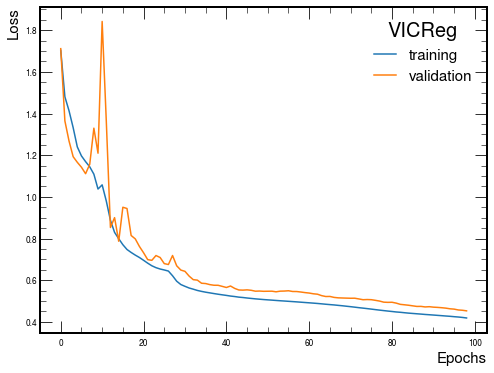

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    range(len(losses_train_VICRreg[1:])),
    losses_train_VICRreg[1:],
    label="training",
)
ax.plot(
    range(len(losses_valid_VICRreg[1:])),
    losses_valid_VICRreg[1:],
    label="validation",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="VICReg", loc="best", title_fontsize=20, fontsize=15);

# Train MLPF

In [16]:
class MLPF(nn.Module):
    def __init__(
        self,
        #        input_dim=COMMON_X + 34 + 200,
        input_dim=34,
        embedding_dim=34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF, self).__init__()

        self.act = nn.ELU

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    input_dim,
                    input_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=k,
                )
            )

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        #         embedding = self.nn0(input_)
        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(input_, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [41]:
def compute_weights(target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


def train_mlpf(data, batch_size, model, with_VICReg, epochs):

    data_train = data[:4000]
    data_val = data[4000:5000]
    data_test = data[5000:]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    val_loader = torch_geometric.loader.DataLoader(data_val, batch_size)
    test_loader = torch_geometric.loader.DataLoader(data_test, batch_size)

    lr = 1e-3
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr
    )  # , momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    encoder.eval()
    decoder.eval()

    for epoch in tqdm(range(epochs)):

        model.train()
        loss_train = 0
        for batch in tqdm(train_loader):
            if with_VICReg:
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(
                    tracks, clusters
                )
                ### POOLING
                pooled_tracks = global_mean_pool(
                    embedding_tracks, tracks.batch
                )
                pooled_clusters = global_mean_pool(
                    embedding_clusters, clusters.batch
                )
                ### DECODE
                out_tracks, out_clusters = decoder(
                    pooled_tracks, pooled_clusters
                )

                # use the learnt representation as your input as well as the global feature vector
                #                     tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                tracks.x = embedding_tracks
                #                     clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)
                clusters.x = embedding_clusters

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch

            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            weights = compute_weights(
                target_ids, num_classes=6
            )  # to accomodate class imbalance
            loss = torch.nn.functional.cross_entropy(
                pred_ids_one_hot, target_ids, weight=weights
            )  # for classifying PID

            # update parameters
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()

        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                time.time()
                if with_VICReg:
                    # make transformation
                    tracks, clusters = distinguish_PFelements(batch)

                    ### ENCODE
                    embedding_tracks, embedding_clusters = encoder(
                        tracks, clusters
                    )
                    ### POOLING
                    pooled_tracks = global_mean_pool(
                        embedding_tracks, tracks.batch
                    )
                    pooled_clusters = global_mean_pool(
                        embedding_clusters, clusters.batch
                    )
                    ### DECODE
                    out_tracks, out_clusters = decoder(
                        pooled_tracks, pooled_clusters
                    )

                    # use the learnt representation as your input as well as the global feature vector
                    #                     tracks.x = torch.cat([tracks.x, embedding_tracks, out_tracks[tracks.batch]], axis=1)
                    tracks.x = embedding_tracks
                    #                     clusters.x = torch.cat([clusters.x, embedding_clusters, out_clusters[clusters.batch]], axis=1)
                    clusters.x = embedding_clusters

                    event = combine_PFelements(tracks, clusters)

                else:
                    event = batch

                # make mlpf forward pass
                pred_ids_one_hot = model(event)
                pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
                target_ids = event.ygen_id

                weights = compute_weights(
                    target_ids, num_classes=6
                )  # to accomodate class imbalance
                loss = torch.nn.functional.cross_entropy(
                    pred_ids_one_hot, target_ids, weight=weights
                )  # for classifying PID

                loss_valid += loss.detach()

        print(
            f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}"
        )

        losses_train.append(loss_train / len(train_loader))
        losses_valid.append(loss_valid / len(val_loader))

        # early-stopping
        if losses_valid[epoch] < best_val_loss:
            best_val_loss = losses_valid[epoch]
            stale_epochs = 0
        else:
            stale_epochs += 1

    fig, ax = plt.subplots()
    ax.plot(range(len(losses_train[1:])), losses_train[1:], label="training")
    ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    if with_VICReg:
        ax.legend(title="ssl MLPF", loc="best", title_fontsize=20, fontsize=15)
    else:
        ax.legend(
            title="native MLPF", loc="best", title_fontsize=20, fontsize=15
        )
    return losses_train, losses_valid

In [72]:
# train ssl version of MLPF
# model_ssl = MLPF(COMMON_X + 34 + 200)
model_ssl = MLPF(34)
print(
    "Num of model paramaters: ",
    sum(p.numel() for p in model_ssl.parameters() if p.requires_grad),
)

Num of model paramaters:  28366



epoch 0 - train: 135.347 - valid: 31.53 - stale=0



epoch 1 - train: 124.318 - valid: 30.721 - stale=0



epoch 2 - train: 121.797 - valid: 30.199 - stale=0



epoch 3 - train: 119.916 - valid: 29.769 - stale=0



epoch 4 - train: 118.319 - valid: 29.394 - stale=0



epoch 5 - train: 116.897 - valid: 29.051 - stale=0



epoch 6 - train: 115.576 - valid: 28.729 - stale=0



epoch 7 - train: 114.32 - valid: 28.42 - stale=0



epoch 8 - train: 113.114 - valid: 28.122 - stale=0



epoch 9 - train: 111.95 - valid: 27.834 - stale=0



epoch 10 - train: 110.814 - valid: 27.551 - stale=0



epoch 11 - train: 109.695 - valid: 27.272 - stale=0



epoch 12 - train: 108.584 - valid: 26.995 - stale=0



epoch 13 - train: 107.491 - valid: 26.724 - stale=0



epoch 14 - train: 106.422 - valid: 26.459 - stale=0



epoch 15 - train: 105.372 - valid: 26.199 - stale=0



epoch 16 - train: 104.341 - valid: 25.943 - stale=0



epoch 17 - train: 103.326 - valid: 25.691 - stale=0



epoch 18 - train: 102.322 - valid: 25.442 - stale=0



epoch 19 - train: 101.327 - valid: 25.194 - stale=0



epoch 20 - train: 100.339 - valid: 24.949 - stale=0



epoch 21 - train: 99.358 - valid: 24.706 - stale=0



epoch 22 - train: 98.385 - valid: 24.464 - stale=0



epoch 23 - train: 97.419 - valid: 24.225 - stale=0



epoch 24 - train: 96.464 - valid: 23.989 - stale=0



epoch 25 - train: 95.522 - valid: 23.757 - stale=0



epoch 26 - train: 94.595 - valid: 23.528 - stale=0



epoch 27 - train: 93.687 - valid: 23.305 - stale=0



epoch 28 - train: 92.8 - valid: 23.088 - stale=0



epoch 29 - train: 91.936 - valid: 22.876 - stale=0



epoch 30 - train: 91.096 - valid: 22.671 - stale=0



epoch 31 - train: 90.281 - valid: 22.471 - stale=0



epoch 32 - train: 89.487 - valid: 22.278 - stale=0



epoch 33 - train: 88.72 - valid: 22.091 - stale=0



epoch 34 - train: 87.986 - valid: 21.915 - stale=0



epoch 35 - train: 87.292 - valid: 21.747 - stale=0



epoch 36 - train: 86.634 - valid: 21.589 - stale=0



epoch 37 - train: 86.01 - valid: 21.439 - stale=0



epoch 38 - train: 85.42 - valid: 21.297 - stale=0



epoch 39 - train: 84.861 - valid: 21.163 - stale=0



epoch 40 - train: 84.335 - valid: 21.036 - stale=0



epoch 41 - train: 83.84 - valid: 20.917 - stale=0



epoch 42 - train: 83.376 - valid: 20.805 - stale=0



epoch 43 - train: 82.942 - valid: 20.701 - stale=0



epoch 44 - train: 82.537 - valid: 20.604 - stale=0



epoch 45 - train: 82.165 - valid: 20.515 - stale=0



epoch 46 - train: 81.819 - valid: 20.43 - stale=0



epoch 47 - train: 81.497 - valid: 20.352 - stale=0



epoch 48 - train: 81.196 - valid: 20.28 - stale=0



epoch 49 - train: 80.915 - valid: 20.213 - stale=0



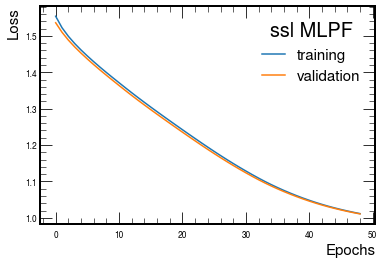

In [73]:
batch_size = 50
losses_train_ssl, losses_valid_ssl = train_mlpf(
    data, batch_size, model_ssl, with_VICReg=True, epochs=50
)

In [47]:
class MLPF_native(nn.Module):
    def __init__(
        self,
        input_dim=8,
        embedding_dim=34,
        num_classes=6,
        num_convs=2,
        k=8,
    ):
        super(MLPF_native, self).__init__()

        self.act = nn.ELU

        # embedding
        self.nn0 = nn.Sequential(
            nn.Linear(input_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, embedding_dim),
        )

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=k,
                )
            )

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(embedding_dim, 126),
            self.act(),
            nn.Linear(126, 126),
            self.act(),
            nn.Linear(126, num_classes),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # embedding
        embedding = self.nn0(input_)

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(embedding, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id

In [48]:
model_native = MLPF_native(input_dim=COMMON_X + 1)
print(
    "Num of model paramaters: ",
    sum(p.numel() for p in model_native.parameters() if p.requires_grad),
)

Num of model paramaters:  66326


In [46]:
# train native MLPF
batch_size = 50
losses_train_native, losses_valid_native = train_mlpf(
    data, batch_size, model_native, with_VICReg=False, epochs=50
)

KeyboardInterrupt: 

## Compare native vs SSL

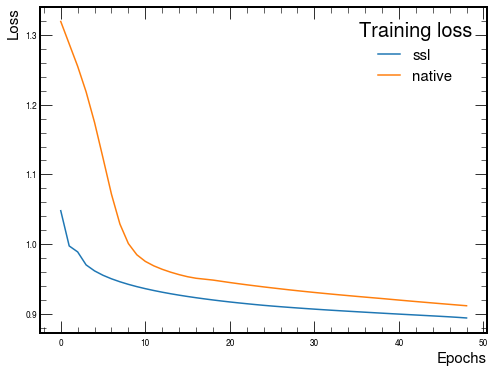

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(losses_train_ssl[1:])), losses_train_ssl[1:], label="ssl")
ax.plot(
    range(len(losses_train_native[1:])),
    losses_train_native[1:],
    label="native",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="Training loss", loc="best", title_fontsize=20, fontsize=15);

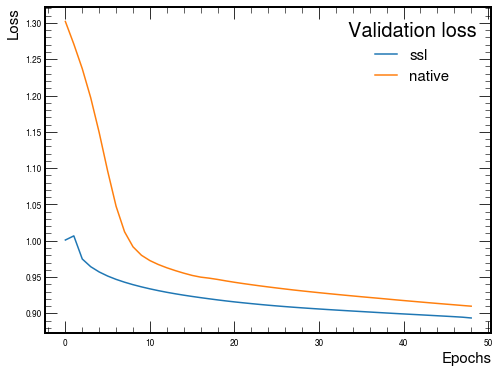

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(losses_valid_ssl[1:])), losses_valid_ssl[1:], label="ssl")
ax.plot(
    range(len(losses_valid_native[1:])),
    losses_valid_native[1:],
    label="native",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="Validation loss", loc="best", title_fontsize=20, fontsize=15);

## Evaluate the SSL against native MLPF

In [69]:
test_loader = torch_geometric.loader.DataLoader(data[5000:], batch_size)

In [18]:
def evaluate_mlpf(model, with_VICReg):
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes))

    model.eval()
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        t = time.time()
        for i, batch in tqdm(enumerate(test_loader)):
            if with_VICReg:
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(
                    tracks, clusters
                )
                ### POOLING
                pooled_tracks = global_mean_pool(
                    embedding_tracks, tracks.batch
                )
                pooled_clusters = global_mean_pool(
                    embedding_clusters, clusters.batch
                )
                ### DECODE
                out_tracks, out_clusters = decoder(
                    pooled_tracks, pooled_clusters
                )

                # use the learnt representation as your input as well as the global feature vector
                tracks.x = embedding_tracks
                clusters.x = embedding_clusters

                event = combine_PFelements(tracks, clusters)

            else:
                event = batch

            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            conf_matrix += sklearn.metrics.confusion_matrix(
                target_ids.detach().cpu(),
                pred_ids.detach().cpu(),
                labels=range(num_classes),
            )
        print(f"Time taken is {round(time.time() - t,2)}s")
    return conf_matrix


CLASS_NAMES_CLIC_LATEX = [
    "none",
    "chhad",
    "nhad",
    "$\gamma$",
    "$e^\pm$",
    "$\mu^\pm$",
]


def plot_conf_matrix(cm, title):
    import itertools

    cmap = plt.get_cmap("Blues")
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(8, 6))

    ax = plt.axes()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:0.2f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=15,
        )
    plt.title(title, fontsize=25)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)

    plt.xticks(
        range(len(CLASS_NAMES_CLIC_LATEX)),
        CLASS_NAMES_CLIC_LATEX,
        rotation=45,
        fontsize=15,
    )
    plt.yticks(
        range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, fontsize=15
    )

    plt.tight_layout()

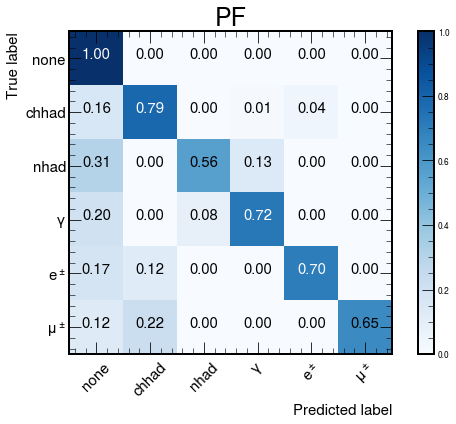

In [79]:
# make confusion matrix of PF for comparison
batch_size = 50

num_classes = 6
conf_matrix_pf = np.zeros((num_classes, num_classes))

for i, batch in tqdm(enumerate(test_loader)):

    # make mlpf forward pass
    target_ids = batch.ygen_id
    pred_ids = batch.ycand_id

    conf_matrix_pf += sklearn.metrics.confusion_matrix(
        target_ids.detach().cpu(),
        pred_ids.detach().cpu(),
        labels=range(num_classes),
    )
plot_conf_matrix(conf_matrix_pf, "PF")


Time taken is 150.4s


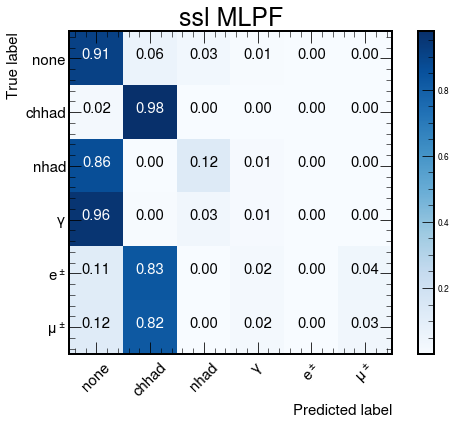

In [80]:
batch_size = 100
conf_matrix_ssl = evaluate_mlpf(model_ssl, with_VICReg=True)
plot_conf_matrix(conf_matrix_ssl, "ssl MLPF")


Time taken is 100.82s


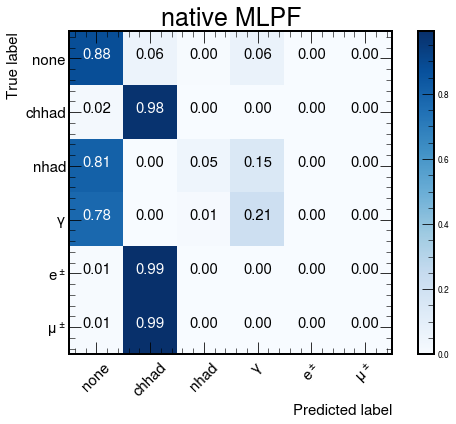

In [101]:
conf_matrix = evaluate_mlpf(model_native, with_VICReg=False)
plot_conf_matrix(conf_matrix, "native MLPF")

In [107]:
print(
    "Num of ssl mlpf model paramaters: ",
    sum(p.numel() for p in model_ssl.parameters() if p.requires_grad),
)

Num of ssl mlpf model paramaters:  202652


In [108]:
print(
    "Num of native mlpf model paramaters: ",
    sum(p.numel() for p in model_native.parameters() if p.requires_grad),
)

Num of native mlpf model paramaters:  198920


## Test from script

In [27]:
test_loader = torch_geometric.loader.DataLoader(data[5000:], batch_size)

In [22]:
# downstream model
NUM_CLASSES = 6


class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=34,
        width=126,
        num_convs=2,
        k=8,
    ):
        super(MLPF, self).__init__()

        self.act = nn.ELU

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    input_dim,
                    input_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=k,
                )
            )

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(input_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, NUM_CLASSES),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(input_, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id


class ENCODER(nn.Module):
    def __init__(
        self,
        width=126,
        embedding_dim=34,
        num_convs=2,
        space_dim=4,
        propagate_dim=22,
        k=8,
    ):
        super(ENCODER, self).__init__()

        self.act = nn.ELU

        ### 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(TRACKS_X, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(CLUSTERS_X, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )

        ### 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=space_dim,
                    propagate_dimensions=propagate_dim,
                    k=k,
                )
            )

    def forward(self, tracks, clusters):

        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)

        return embedding_tracks, embedding_clusters


# define the decoder that expands the latent representations of tracks and clusters
class DECODER(nn.Module):
    def __init__(
        self,
        input_dim=34,
        width=126,
        output_dim=200,
    ):
        super(DECODER, self).__init__()

        self.act = nn.ELU

        ############################ DECODER
        self.expander = nn.Sequential(
            nn.Linear(input_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, output_dim),
        )

    def forward(self, out_tracks, out_clusters):

        return self.expander(out_tracks), self.expander(out_clusters)

In [35]:
encoder_state_dict = torch.load(
    f"ssl/encoder_best_epoch_weights.pth", map_location="cpu"
)
with open(f"ssl/encoder_model_kwargs.pkl", "rb") as f:
    encoder_model_kwargs = pkl.load(f)
encoder = ENCODER(**encoder_model_kwargs)
encoder.load_state_dict(encoder_state_dict)

decoder_state_dict = torch.load(
    f"ssl/decoder_best_epoch_weights.pth", map_location="cpu"
)
with open(f"ssl/decoder_model_kwargs.pkl", "rb") as f:
    decoder_model_kwargs = pkl.load(f)
decoder = DECODER(**decoder_model_kwargs)
decoder.load_state_dict(decoder_state_dict)

mlpf_state_dict = torch.load(
    f"ssl/mlpf_best_epoch_weights.pth", map_location="cpu"
)
with open(f"ssl/mlpf_model_kwargs.pkl", "rb") as f:
    mlpf_model_kwargs = pkl.load(f)
mlpf = MLPF(**mlpf_model_kwargs)
mlpf.load_state_dict(mlpf_state_dict)

<All keys matched successfully>


Time taken is 93.74s


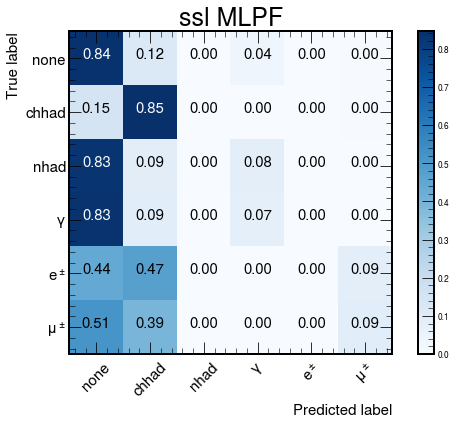

In [38]:
batch_size = 1000
conf_matrix_ssl = evaluate_mlpf(mlpf, with_VICReg=True)
plot_conf_matrix(conf_matrix_ssl, "ssl MLPF")